In [1]:
%matplotlib inline

In [2]:
import sys
import lumapi


C:\Program Files\Lumerical\v221\api\python\lumapi.py:796: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


In [3]:
diretorio = r'C:\Users\gson5\Downloads\ERICK TRALHAS\FOTÔNICA\PROJETO'
arquivos_fsp = ['CROSS_2D.fsp', 'CROSS_3D.fsp']

# 0 2D
# 1 2D

tridimensional = 0

CONFIGURATION FILE {'root': 'C:\\Program Files\\Lumerical\\v221\\api\\python', 'lumapi': 'C:\\Program Files\\Lumerical\\v221\\api\\python'}
Accurate interface detection enabled


C:\Program Files\Lumerical\v221\api\python\lumopt\utilities\plotter.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[0.2 1. ]
 [0.2 1. ]
 [0.2 1. ]
 [0.2 1. ]
 [0.2 1. ]
 [0.2 1. ]
 [0.2 1. ]
 [0.2 1. ]
 [0.2 1. ]
 [0.2 1. ]]
start = [0.25       0.28888889 0.32777778 0.36666667 0.40555556 0.44444444
 0.48333333 0.52222222 0.56111111 0.6       ]
Making forward solve
Making adjoint solve
Running solves
Processing forward solve
FOM = 0.7622493327713089
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 1e-10
..........
Saved frame
Making forward solve
Making adjoint solve
Running solves
Processing forward solve
Finished saving frames to C:\Users\gson5\AppData\Local\Temp\ipykernel_12020\opts_0\optimization.png


UserWarning: FDTD simulation did not complete successfully: status 0.0

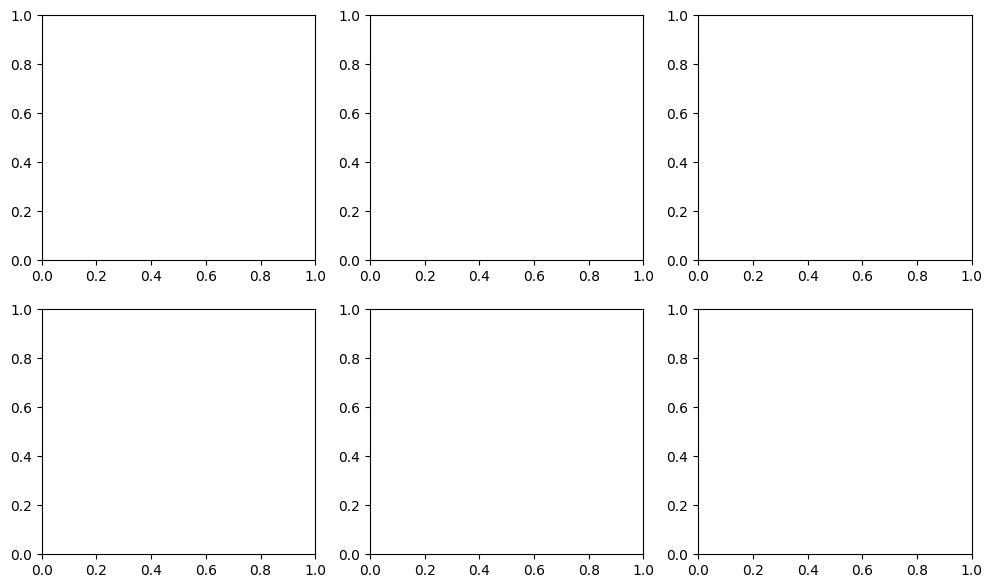

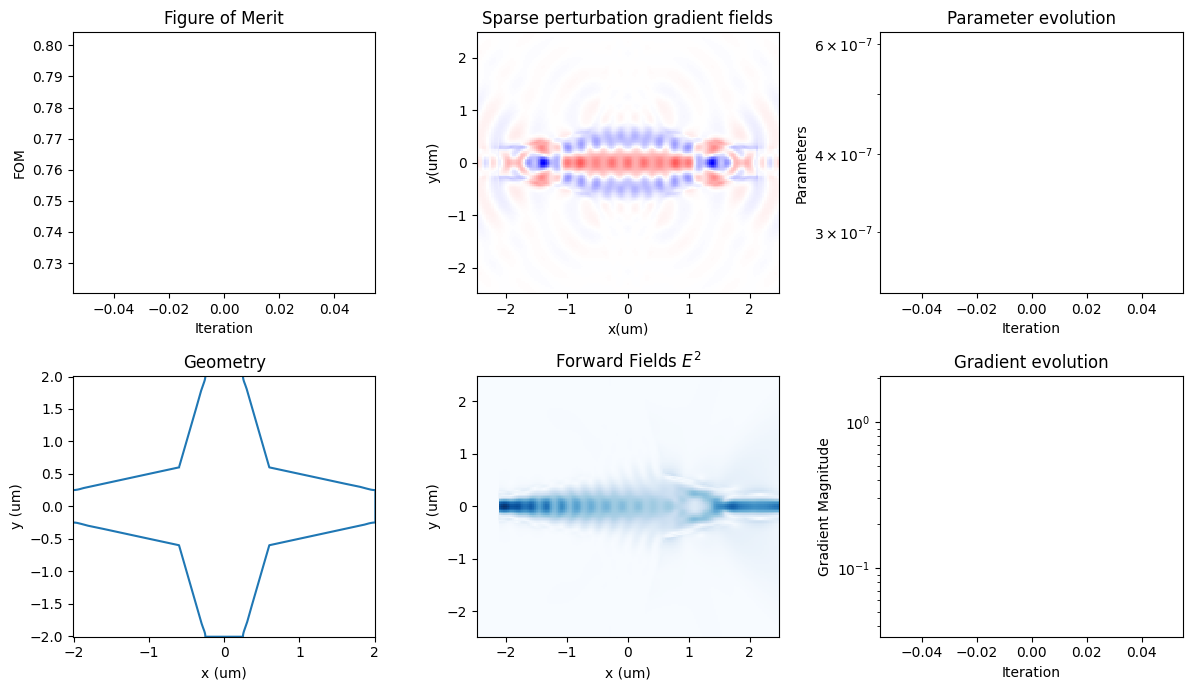

In [4]:
""" Copyright chriskeraly
    Copyright (c) 2019 Lumerical Inc. """

######## IMPORTS ########
import os
import numpy as np
import scipy as sp
import matplotlib

from lumopt.utilities.wavelengths import Wavelengths
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.figures_of_merit.modematch import ModeMatch
from lumopt.optimizers.generic_optimizers import ScipyOptimizers
from lumopt.optimization import Optimization
from lumopt.utilities.plotter import Plotter
from lumopt.utilities.materials import Material

######## DEFINE BASE SIMULATION ########
crossing_base = os.path.join(diretorio, arquivos_fsp[tridimensional])

######## DEFINE SPECTRAL RANGE #########
wavelengths = Wavelengths(start = 1530e-9, stop = 1565e-9, points = 10)

######## DEFINE OPTIMIZABLE GEOMETRY ########
def cross(params):
    y_end = params[-1]
    x_end = 0 - y_end
    points_x = np.concatenate(([-2.01e-6], np.linspace(-2e-6, x_end, 10)))
    points_y = np.concatenate(([0.25e-6], params))
    n_interpolation_points = 50
    polygon_points_x = np.linspace(min(points_x), max(points_x), n_interpolation_points)
    interpolator = sp.interpolate.interp1d(points_x, points_y, kind = 'cubic')
    polygon_points_y = [max(min(point, 1e-6), -1e-6) for point in interpolator(polygon_points_x)]
    pplu = [(x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    ppld = [(x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    ppdl = [(-y, x) for x, y in zip(polygon_points_x, polygon_points_y)]
    ppdr = [(y, x) for x, y in zip(polygon_points_x, polygon_points_y)]
    pprd = [(-x, -y) for x, y in zip(polygon_points_x, polygon_points_y)]
    ppru = [(-x, y) for x, y in zip(polygon_points_x, polygon_points_y)]
    ppur = [(y, -x) for x, y in zip(polygon_points_x, polygon_points_y)]
    ppul = [(-y, -x) for x, y in zip(polygon_points_x, polygon_points_y)]
    polygon_points = np.array(pplu[::-1] + ppld[:-1] + ppdl[::-1] + ppdr[:-1] + pprd[::-1] + ppru[:-1] + ppur[::-1] + ppul[:-1])
    return polygon_points

if(tridimensional == 1):
    polygon_geometry = FunctionDefinedPolygon(func = cross, initial_params = np.linspace(0.25e-6, 0.6e-6, 10), bounds = [(0.2e-6, 1e-6)]*10, z = 0.0, depth = 220.0e-9, eps_out = Material(1.4442 ** 2), eps_in = Material(3.4784 ** 2, mesh_order = 2), edge_precision = 5, dx = 1.0e-9)
elif (tridimensional == 0):
    polygon_geometry = FunctionDefinedPolygon(func = cross, initial_params = np.linspace(0.25e-6, 0.6e-6, 10), bounds = [(0.2e-6, 1e-6)]*10, z = 0.0, depth = 220.0e-9, eps_out = 1.4442 ** 2, eps_in = 3.4784 ** 2, edge_precision = 5, dx = 0.1e-9)

######## DEFINE FIGURE OF MERIT ########
mode_fom = ModeMatch(monitor_name = 'fom', mode_number = 1, direction = 'Forward',  multi_freq_src = True, target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

######## DEFINE OPTIMIZATION ALGORITHM ########
scipy_optimizer = ScipyOptimizers(max_iter = 20, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-3)

######## PUT EVERYTHING TOGETHER ########
opt = Optimization(base_script = crossing_base, wavelengths = wavelengths, fom = mode_fom, geometry = polygon_geometry, optimizer = scipy_optimizer, hide_fdtd_cad = False, use_deps = True)

plotter = Plotter(movie=False, plot_history=True, plot_fields=True)

######## RUN THE OPTIMIZER ########
opt.run()